# Machine Learning I, Programming Exercise 3

## 1. Gradient Descent
*Gradient Descent* is an iterative method to find a local minimum of a function $f: \mathbb{R}^{d} \to \mathbb{R}$. The algorithm starts with an arbitrary estimate $\mathbf{x}^{(0)} \in \mathbb{R}^{d}$ and produces a sequence of estimates $\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \ldots$ according to the following update rule:
\begin{equation*}
    \mathbf{x}^{(t+1)} = \mathbf{x}^{(t)} - \alpha_t \nabla f(\mathbf{x}^{(t)}),
\end{equation*}
where $\alpha_t \in \mathbb{R}_{+}$ is called the *step size* (note that it is allowed to change in every iteration). Since the gradient of $f$ points in the direction of steepest ascent, subtracting the gradient updates the estimate towards the direction of steepest descent. The algorithm terminates when $\lVert \nabla f(\mathbf{x}^{(t)}) \rVert < \varepsilon$ for some small $\varepsilon > 0$, i.e., when it (approximately) reaches a critical point of $f$. Note that convergence is not guaranteed in the general case, so it makes sense to enforce a hard limit on the number of iterations.

In this exercise we are going to perform gradient descent on Himmelblau's function, a polynomial of degree four in two variables:
\begin{align}
    f: && \mathbb{R}^{2} &\to \mathbb{R}\\
    &&\left(\begin{matrix}x \\ y\end{matrix}\right) &\mapsto (x^2 + y - 11)^2 + (x + y^2 - 7)^2
\end{align}
Specifically, your tasks are as follows:
1. Implement the gradient descent method on Himmelblau's function. Your routine should return the whole list of iterates $\mathbf{x}^{(0)}, \mathbf{x}^{(1)}, \ldots$, so that you can also visualize the trajectory. The code skeleton already plots Himmelblau's function, so you can use the [`plot`](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#line-plots) method of Matplotlib's `Axes3D` object to draw the trajectory into the same figure. Choose $\mathbf{x}^{(0)}$ uniformly random from the square spanned by the two points $(\begin{matrix}-6 & -6\end{matrix})^T$ and $(\begin{matrix}6 & 6\end{matrix})^T$ and run the algorithm for several draws of $\mathbf{x}^{(0)}$.
2. Play around with the step size and visualize the result to see what happens.
3. Another popular method for finding local optima is called *Newton's Method*. It works exactly in the same way as gradient descent, except that the step size in the update formula is replaced by the inverse of the hessian matrix of $f$:
\begin{equation*}
    \mathbf{x}^{(t+1)} = \mathbf{x}^{(t)} - H_f(\mathbf{x}^{(t)})^{-1} \nabla f(\mathbf{x}^{(t)})
\end{equation*}
Implement Newton's method in the same way as you did for gradient descent including the visualization and run the cell for a few times to see what happens.
4. Compare the two methods. What differences did you notice regarding, for example, the number of iterations till convergence, the trajectories, etc.?
5. You have probably noticed by now that our simple version of Newton's method often ends up in saddle points or even the local maximum. One way of mitigating this is to perform the update step only if the hessian matrix $H_f(\mathbf{x}^{(t)})$ is positive definite and to fall back to a simple gradient descent update otherwise. Implement and visualize this 'improved' version of Newton's method.
6. Create a plot that visualises the trajectory for each of the three methods using a step size of 0.01, where applicable, and starting from the five different points that are deterministically generateded by the PRNG with seed 654321. Also print the final values for $x$ and $y$ (i.e., the supposed critical points) that the optimisation procedure outputs.

In [2]:
import numpy as np


def himmelblau_wrapper(func):
    """
    This decorator allows passing one array containing [x,y]
    to the functions instead of both parameters separately
    """
    def wrapper(x):
        return func(*x)
    
    return wrapper

@himmelblau_wrapper
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

@himmelblau_wrapper
def himmelblau_gradient(x, y):
    x_bar = 4*x*(x**2 + y - 11) + 2*(x + y**2 - 7)
    y_bar = 2*(x**2 + y - 11) + 4*y*(x + y**2 - 7)
    return np.array([x_bar, y_bar])

@himmelblau_wrapper
def himmelblau_hessian(x, y):
    xx_bar = 4*(x**2 + y - 11) + 8*x**2 + 2
    yy_bar = 2 + 4*(x + y**2 - 7) + 8*y**2
    xy_bar = 4*x + 4*y
    return np.array([[xx_bar, xy_bar], [xy_bar, yy_bar]])


def gradient_descent(f, f_gradient, f_hessian, x_0, step_size=0.01, max_iter=1000, eps=1e-7):
    x = x_0.copy()
    trajectory = []
    
    if not callable(step_size):
        _step = lambda it: step_size
    else:
        _step = step_size
    
    for i in range(max_iter):
        trajectory.append(x.copy())
        grad = f_gradient(x)
        x -= _step(i) * grad
        
        if np.sum(grad**2) < eps*eps:
            break
    
    return np.stack(trajectory, axis=-1)

def newtons_method(f, f_gradient, f_hessian, x_0, step_size=0.01, max_iter=100, eps=1e-7):
    x = x_0.copy()
    trajectory = []

    if not callable(step_size):
        _step = lambda it: step_size
    else:
        _step = step_size

    for i in range(max_iter):
        trajectory.append(x.copy())
        grad = f_gradient(x)
        hessian = f_hessian(x)
        
        x -= np.matmul(np.linalg.inv(hessian), grad)
        
        if np.sum(grad**2) < eps*eps:
            break

    return np.stack(trajectory, axis=-1)

def improved_newton(f, f_gradient, f_hessian, x_0, step_size=0.01, max_iter=100, eps=1e-7):
    x = x_0.copy()
    trajectory = []

    if not callable(step_size):
        _step = lambda it: step_size
    else:
        _step = step_size

    for i in range(max_iter):
        trajectory.append(x.copy())
        grad = f_gradient(x)
        hessian = f_hessian(x)    
        eigen = np.linalg.eigvalsh(hessian)
        
        if np.all(eigen > 0):
            x -= np.linalg.solve(hessian, grad)
        else:
            x -= _step(i) * grad
        
        if np.sum(grad**2) < eps*eps:
            break

    return np.stack(trajectory, axis=-1)

gradient_descent found a critical point for start value (-2.639, 1.291) at (-2.805, 3.131)!
gradient_descent found a critical point for start value (4.538, 3.355) at (3.000, 2.000)!
gradient_descent found a critical point for start value (5.123, -3.441) at (3.584, -1.848)!
gradient_descent found a critical point for start value (-3.305, -2.728) at (-3.779, -3.283)!
gradient_descent found a critical point for start value (-5.561, -2.020) at (-3.779, -3.283)!
newtons_method found a critical point for start value (-2.639, 1.291) at (-3.073, -0.081)!
newtons_method found a critical point for start value (4.538, 3.355) at (3.000, 2.000)!
newtons_method found a critical point for start value (5.123, -3.441) at (3.584, -1.848)!
newtons_method found a critical point for start value (-3.305, -2.728) at (-3.779, -3.283)!
newtons_method found a critical point for start value (-5.561, -2.020) at (-2.805, 3.131)!
improved_newton found a critical point for start value (-2.639, 1.291) at (-2.805, 3.1

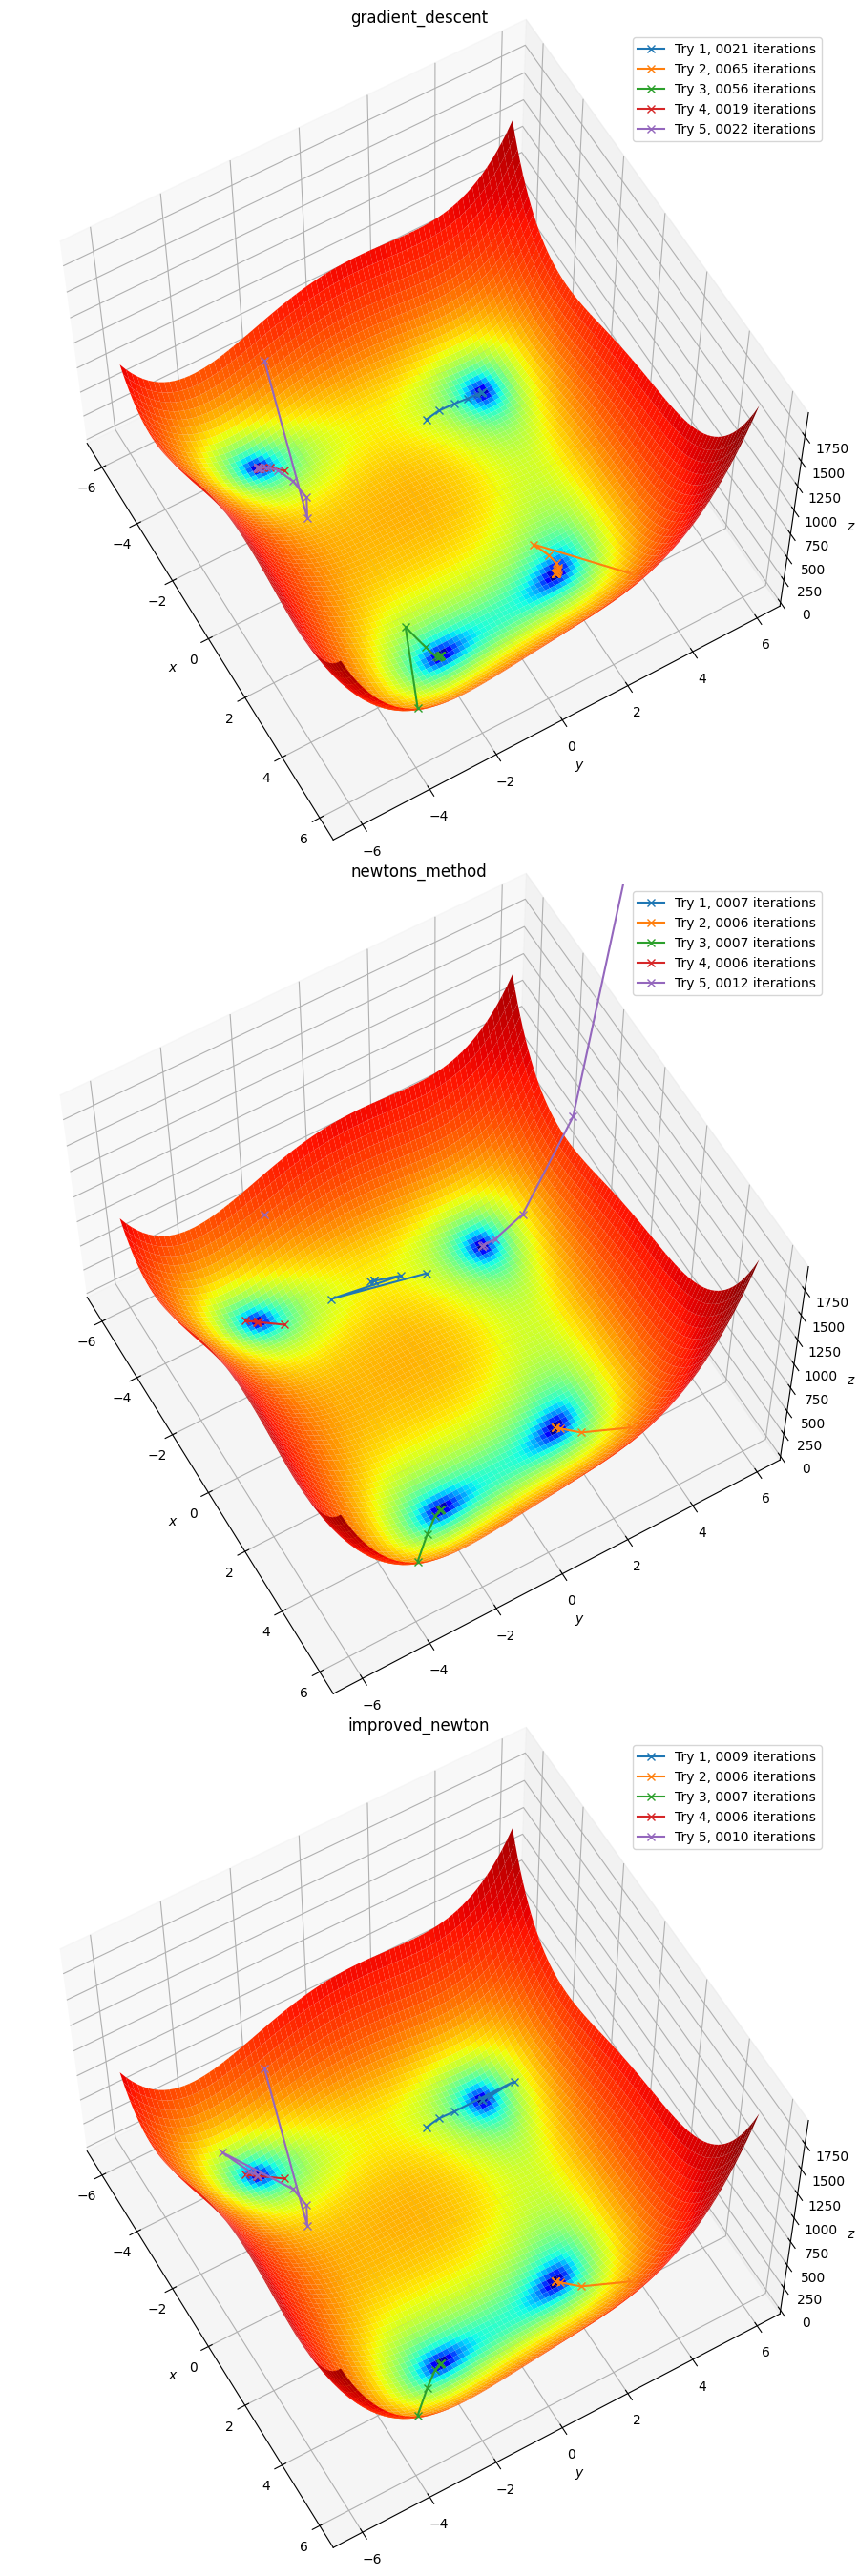

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

def make_himmelblau_plot(ax, x, y):
    ax.view_init(elev=60, azim=-30)
    ax.plot_surface(x, y, himmelblau([x,y]), cstride=1, rstride=1, norm=colors.LogNorm(), cmap=plt.cm.jet)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

x = np.arange(-6, 6, 0.15)
y = np.arange(-6, 6, 0.15)
x, y = np.meshgrid(x, y)

# Please don't change the start point generation for your submission
retries = 5
rng = np.random.default_rng(654321)
x_0 = rng.uniform(-6, 6, size=(retries, 2))

methods = [gradient_descent, newtons_method, improved_newton]

fig, axes = plt.subplots(len(methods), 1, figsize=(12, 27), subplot_kw=dict(projection='3d'))
for ax, method in zip(axes, methods):
    name = method.__name__
    ax.set_title(name)
    make_himmelblau_plot(ax, x, y)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    z_min, z_max = ax.get_zlim()
    
    for t in range(retries):
        trace = method(himmelblau, himmelblau_gradient, himmelblau_hessian, x_0[t])
        ax.plot(trace[0], trace[1], himmelblau(trace), marker='x', 
                label=f'Try {t+1:d}, {trace.shape[1]:04d} iterations', zorder=3)
        print(f'{name} found a critical point for start value ({x_0[t,0]:.3f}, {x_0[t,1]:.3f}) '
              f'at ({trace[0,-1]:.3f}, {trace[1,-1]:.3f})!')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.legend()

fig.tight_layout()
plt.show()
plt.close(fig)

## 2. SVM Implementation
It is finally time to get your hands dirty and implement the SVM yourselves! Just for your convenience, here is the unconstrained optimization problem for the linear SVM that we want to train on the dataset $D = \{(\mathbf{x}^{(1)}, y^{(1)}), (\mathbf{x}^{(2)}, y^{(2)}), \ldots, (\mathbf{x}^{(n)}, y^{(n)})\}$:
\begin{equation*}
    \min_{\mathbf{w} \in \mathbb{R}^d, b \in \mathbb{R}} \frac{1}{2} \lVert \mathbf{w} \rVert^2 + \frac{C}{n} \sum_{i=1}^{n} \max\left(0, 1 - y^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)} + b)\right)
\end{equation*}

1. Implement the support vector machine using (non-stochastic) gradient descent. Use the general gradient descent function that you have already written in exercise 1 of this sheet. The implementation should also include a flag that determines if a bias parameter $b$ should be learned during training or not. Choose $\mathbf{w}^{(0)} = \mathbf{0}$ and $b^{(0)} = 0$.
2. Now implement the SVM via stochastic gradient descent as well, i.e., sample a random batch of a given size from the training data for each gradient computation. Using your results from the previous part, this should only require you to change the wrapper function for computing the gradient.
3. Train both implementations on the simple two-dimensional toy dataset. Don't allow the SVM to learn a bias, i.e., $b$ should be zero.
4. Visualize the SVMs decision boundary and the optimization trajectory using the given code skeleton. This is also a good chance to see if your implementation works properly.
5. Produce a plot like in part 4 for both methods using the following parameter values: `C=1, step_size=0.1, batch_size=10, max_iter=1000`. Also print the value of $\mathbf{w}$ after training.
6. (OPTIONAL) Play around with parameters like step size, batch size, etc., and observe what changes.

Final value of normal vector w for Gradient Descent: [0.41078    0.41301192]
Final value of normal vector w for Stochastic Gradient Descent: [0.44938497 0.37170055]


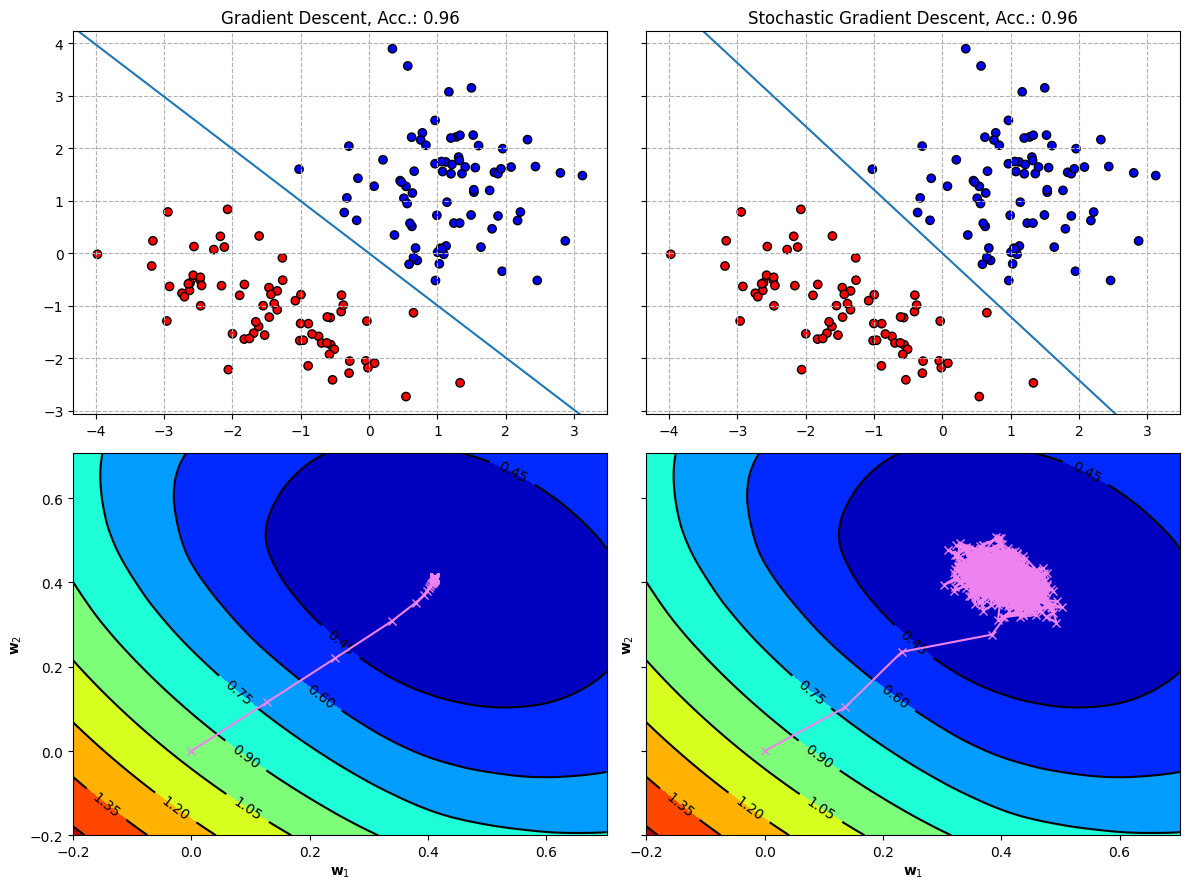

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


def hinge_loss(t):
    return np.maximum(0, 1 - t)

def hinge_gradient(t):
    return np.where(t<1, -1, 0)

def svm_loss(w, b, C, x, y):
    n, d = x.shape
    if w.ndim == 1:
        m = 1
    else:
        m = w.shape[1]
        if isinstance(b, np.ndarray):
            b = b.reshape(1, m)
    w = w.reshape(d, m)
    y = y.reshape(n, 1)
    
    return 0.5*np.sum(w**2, axis=0) + C/x.shape[0] * np.sum(hinge_loss(y*(np.matmul(x, w) + b)), axis=0)

def svm_gradient(w, b, C, x, y):
    # Sorry for the mess, numpy's broadcasting rules are a bit verbose at times
    n, d = x.shape
    if w.ndim == 1:
        m = 1
    else:
        m = w.shape[1]
        if isinstance(b, np.ndarray):
            b = b.reshape(1, m) 
    w = w.reshape(d, m)
    y = y.reshape(n, 1)
    
    w_bar = w + C/n * np.einsum('nm,nd->dm', hinge_gradient(y*(np.matmul(x, w) + b)), y*x)
    b_bar = C/n * np.sum(hinge_gradient(y*(np.matmul(x, w) + b))*y, axis=0, keepdims=True)
    return np.concatenate([w_bar, b_bar], axis=0).squeeze()

class SVM_GD(BaseEstimator, ClassifierMixin):
    def __init__(self, bias=True, C=1, step_size=0.01, max_iter=1000):
        super(SVM_GD, self).__init__()
        
        self.bias = bias
        self.C = C
        self.step_size = step_size
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        if self.bias:
            f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
            f_grad = lambda w: svm_gradient(w[:-1], w[-1], self.C, X, y)
        else:
            f = lambda w: svm_loss(w[:-1], 0, self.C, X, y)
            f_grad = lambda w: svm_gradient(w[:-1], 0, self.C, X, y)
        
        w_0 = np.zeros(X.shape[1]+1)
        
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)
        self.w = trace[:-1, -1]
        self.b = trace[-1, -1] if self.bias else 0
        return trace

    def predict(self, X):
        if self.w is None or self.b is None:
            raise ValueError('Predict can only be called after supplying training data with fit first!')
        return np.sign(np.matmul(X, self.w) + self.b)
    
class SVM_SGD(SVM_GD):
    def __init__(self, bias=True, batch_size=32, C=1, step_size=0.01, max_iter=1000):
        super(SVM_SGD, self).__init__(bias, C, step_size, max_iter)
        
        self.batch_size = batch_size
    
    def fit(self, X, y):
        if self.bias:
            f = lambda w: svm_loss(w[:-1], w[-1], self.C, X, y)
        else:
            f = lambda w: svm_loss(w[:-1], 0, self.C, X, y)
        
        def f_grad(w):
            from random import sample
            b = w[-1] if self.bias else 0
            w = w[:-1]
            # Sample a random batch from the training data
            batch_ind = sample(range(X.shape[0]), self.batch_size)
            return svm_gradient(w, b, self.C, X[batch_ind], y[batch_ind])
 
        w_0 = np.zeros(X.shape[1]+1)
        
        trace = gradient_descent(f, f_grad, None, w_0, step_size=self.step_size, max_iter=self.max_iter)
        self.w = trace[:-1, -1]
        self.b = trace[-1, -1] if self.bias else 0
        return trace


def apply_line(x, w, b):
    a = -w[0]/w[1]
    b = -b/w[1]
    return a*x+b


# Generate toy data
# Please don't change the data generation seeds or methods for your submission
n = 200
X, Y = make_classification(n, n_features=2, n_redundant=0, 
                           n_clusters_per_class=1, class_sep=1.2, random_state=12345)

# Change labels from 0,1 to -1,1
Y *= 2; Y -= 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

svm_gd = SVM_GD(bias=False, step_size=0.1, C=1)
svm_sgd = SVM_SGD(bias=False, batch_size=10, C=1, step_size=0.1)
classifiers = [(svm_gd, 'Gradient Descent'), (svm_sgd, 'Stochastic Gradient Descent')]

traces = []
cmap = colors.ListedColormap([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex='row', sharey='row')
for (clf, name), ax in zip(classifiers, axes[0]):
    # Plot dataset
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap, edgecolor='k')
    ax.grid(linestyle='dashed')
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # Train classifier and plot decision boundary
    traces.append(clf.fit(X_train, Y_train))
    if clf.w[1] == 0:
        # vertical line
        x_line = - clf.b / clf.w[0]
        ax.axvline(x_line)
    else:
        x_line = np.array([x_min, x_max])
        ax.plot(x_line, apply_line(x_line, clf.w, clf.b))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'{name}, Acc.: {clf.score(X_test, Y_test):.2f}')


# Plot trace
res = 100
w_min = np.minimum(np.min(traces[0], axis=1), np.min(traces[1], axis=1))
w_max = np.maximum(np.max(traces[0], axis=1), np.max(traces[1], axis=1))
w_1 = np.linspace(w_min[0]-0.2, w_max[0]+0.2, res)
w_2 = np.linspace(w_min[1]-0.2, w_max[1]+0.2, res)
w_1, w_2 = np.meshgrid(w_1, w_2)
for (clf, name), trace, ax in zip(classifiers, traces, axes[1]):
    loss = svm_loss(np.stack([w_1.ravel(), w_2.ravel()], axis=0), 0, clf.C, X_train, Y_train.reshape(-1, 1))
    ax.contourf(w_1, w_2, loss.reshape(w_1.shape), levels=10, cmap=plt.cm.jet)
    cont = ax.contour(w_1, w_2, loss.reshape(w_1.shape), levels=10, colors='black')
    ax.clabel(cont, inline=1)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.plot(trace[0], trace[1], marker='x', c='violet', zorder=5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('$\mathbf{w}_1$')
    ax.set_ylabel('$\mathbf{w}_2$')
    print(f'Final value of normal vector w for {name}:', clf.w)
    
fig.tight_layout()
plt.show()
plt.close(fig)   